# <center>ПРОЕКТ
___
# <center>Предсказание продаж<br><br>Прогноз количества заказов желтого такси<br><br> Прогнозирование временных рядов на карте

## <center>ВВЕДЕНИЕ

Задача этого проекта — **предсказывать количество поездок в ближайшие часы в каждом районе Нью-Йорка**. Для того, чтобы её решить, сырые данные необходимо агрегировать по часам и районам. Агрегированные данные будут представлять собой почасовые временные ряды с количествами поездок из каждого района. 

**Похожие задачи возникают на практике, если вам необходимо спрогнозировать продажи большого количества товаров в большом количестве магазинов, объём снятия денег в сети банкоматов, посещаемость разных страниц сайта и т.д.**

Нью-Йоркская комиссия по такси и лимузинам (TLC) предоставляет подробные анонимизированные данные о поездках клиентов с 2009 года.

<img src="img/Yellow_cabs.jpg" width=60%>

Сырые данные о поездках в жёлтом такси можно найти на сайте TLC: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml Эти данные разбиты на файлы по месяцам. В каждом из файлов содержится следующая информация о поездках:

- время начала поездки
- время окончания поездки
- долгота и широта точки начала поездки
- долгота и широта точки окончания поездки
- количество пассажиров
- расстояние по счётчику
- тип тарифа (одна из шести категорий)
- способ оплаты (одна из шести категорий)
- стоимость поездки по счётчику
- налог на счётчик
- доплата за поездки в пиковые часы и ночью
- доплата за проезд по платным дорогам
- доплата за проезд, взимаемая с каждой поездки с января 2015
- размер чаевых
- общая стоимость поездки
- провайдер данных (одна из двух категорий)
- бинарный флаг, показывающий, были ли данные о поезде получены немедленно после её окончания, или какое-то время хранились в памяти автомобиля.
Подробнее: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

Задача проекта — предсказывать количество поездок в ближайшие часы в каждом районе Нью-Йорка; для простоты мы определим **прямоугольные районы**. Для того, чтобы её решить, сырые данные необходимо агрегировать по **часам** и **районам**. Агрегированные данные будут представлять собой **почасовые временные ряды с количествами поездок из каждого района**.

Задачу прогнозирования таких рядов можно решать с помощью авторегрессионных моделей, прогнозируя каждый ряд независимо. Ряды явно имеют сложную сезонность — суточную, недельную и годовую, поэтому для их моделирования понадобится использовать модель **ARIMA** с дополнительной регрессией на внешние признаки.

Чтобы улучшить такую модель, можно попытаться **учесть**:

- взаимосвязи между рядами
- дополнительные параметры поездок, которые можно посчитать по исходным данным
- внешние календарные и географические признаки

В ходе выполнения проекта будет использовано:

- работа с геоданными
- прогнозирование временных рядов сложной структуры
- построение и настройка регрессионных моделей, делающих совместные предсказания для большого количества взаимосвязанных рядов

В этом проекте будет скачано и обработано от 10 до 200 гигабайт сырых данных.

## <center>Часть 1. Предобработка данных

#### Сырые данные будем обрабатывать по следующей схеме.

1. Почистим данные от ошибок и аномалий.
2. Отбросим минуты и секунды во времени начала поездки.
3. Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. Разобьем этот прямоугольник на 2500 одинаковых прямоугольных областей — по 50 интервалов вдоль каждой оси.
4. Посчитаем количество поездок за каждый час из каждой области. Если в сырых данных для какой-то пары час-область нет ни одной записи, то в агрегированных данных для неё должен стоять 0.

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta, time
from pandas.tseries.offsets import MonthBegin

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
path_to_data = 'D:\\coursera\python\ml\tasks\projects\time_series_taxi_trip_predict\data'

#### 1. Загрузим данные за май 2016 года.

In [11]:
%%time
data = pd.read_csv('D:\coursera\python\ml\tasks\projects\time_series_taxi_trip_predict\data\yellow_tripdata_2016-05.csv', 
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

IOError: [Errno 2] File D:\coursera\python\ml	asks\projects	ime_series_taxi_trip_predict\data\yellow_tripdata_2016-05.csv does not exist: 'D:\\coursera\\python\\ml\tasks\\projects\time_series_taxi_trip_predict\\data\\yellow_tripdata_2016-05.csv'

In [5]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11836853 entries, 0 to 11836852
Data columns (total 19 columns):
VendorID                 int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: datetime64[ns](2), float64(12), int64(4), object(1)
memory usage: 1.7+ GB


### 2. Проведем фильтрацию
#### а) Удаляем поездки с:

1. нулевой длительностью
- нулевым количеством пассажиров
- нулевым расстоянием поездки по счётчику
- координатами начала, не попадающими в прямоугольник Нью-Йорка

Для пп.4 определим границы Нью-Йорка:

In [7]:
west_bound = -74.25559
east_bound = -73.70001
south_bound = 40.49612
north_bound = 40.91553

In [8]:
%%time
drop_indexes = data[(data['tpep_dropoff_datetime'] == data['tpep_pickup_datetime']) | 
                    (data['passenger_count'] == 0) | 
                    (data['trip_distance'] == 0) | 
                    (west_bound > data['pickup_longitude']) | (data['pickup_longitude'] > east_bound) | 
                    (south_bound > data['pickup_latitude']) | (data['pickup_latitude'] > north_bound)].index

data.drop(drop_indexes, inplace=True)
print(len(data))

11626521
Wall time: 3.38 s


In [9]:
%%time
# начальный альтернативный вариант, Wall time: 11.2 s
filtered_indexes = ((data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']) != timedelta(0)) & \
                    (data['passenger_count'] != 0) & \
                    (data['trip_distance'] != 0) & \
                    (west_bound <= data['pickup_longitude']) & (data['pickup_longitude'] <= east_bound) & \
                    (south_bound <= data['pickup_latitude']) & (data['pickup_latitude'] <= north_bound)

data = data[filtered_indexes]
print(len(data))

11626521
Wall time: 8.41 s


#### б) Отбросим минуты и секунды во времени начала поездки

In [10]:
%%time
# это самый быстрый вариант (имхо: благодаря .dt)
data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].dt.floor('h') 
'''
.dt - это средство для БЫСТРОЙ обработки время-подобных Series-объектов
сочетание .dt.floor() - округляет индекс вниз (floor) до указанной частоты (dt переводит сериес в формат, с которым может 
работать floor, см. также http://qaru.site/questions/414663/convert-pandas-series-to-datetime-in-a-dataframe
и http://pandas.pydata.org/pandas-docs/stable/basics.html#dt-accessor)
'''

Wall time: 929 ms


### 3. Агрегируем данные за май 2016 года по часам и областям 
- Будем использовать функцию **stats.binned_statistic_2d**.    
- Затем проверим, что идентификаторы, которые будут присвоены ячейкам, соответствуют приложенному выше файлу.

оставим в данных только те колонки, которые нам нужны

In [11]:
data = data[['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude']]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11626521 entries, 0 to 11836841
Data columns (total 3 columns):
tpep_pickup_datetime    datetime64[ns]
pickup_longitude        float64
pickup_latitude         float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 354.8 MB


In [13]:
data.head()

,tpep_pickup_datetime,pickup_longitude,pickup_latitude
0,2016-05-01,-73.985901,40.768040
1,2016-05-01,-73.991577,40.744751
2,2016-05-01,-73.993073,40.741573
3,2016-05-01,-73.991943,40.684601
4,2016-05-01,-74.005280,40.740192


In [ ]:
# Здесь показывает, что в data['tpep_pickup_datetime'] нет часов, но если загрузить данные отдельно, то будет видно, что они сохранены.

#### 3.1. Отладка функций для агрегации данных

Отделим 1000 строк для тренировочного датасета

In [17]:
data1000 = data.head(1000)

Делаем 2 функции:

1) Первая агрегирует данные по времени (по часам), где берем поле statistic (оно получилось 50х50) и вытягиваем его

In [18]:
def count_statistic(df, col1='pickup_longitude', col2='pickup_latitude'):
    '''
    агрегируем данные по времени (по часам), берем поле statistic (оно получилось 50х50) и вытягиваем его
    '''
    ret = binned_statistic_2d(df[col1], df[col2], None, 'count', bins=50, 
                              range=[[west_bound, east_bound], [south_bound, north_bound]])
    return ret.statistic.astype(int).ravel()

тестим

In [19]:
s = data1000.groupby('tpep_pickup_datetime').apply(count_statistic)
s

C:\Users\ilyaivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


tpep_pickup_datetime
2016-05-01 00:00:00    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2016-05-04 22:00:00    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
dtype: object

Но нам нужно преобразовать это в датафрейм. Для этого вторая функция

In [20]:
def to_df(s):
    '''
    преобразовываем в датафрейм, в котором названия колонок - идентификаторы ячеек
    ''' 
    df = pd.DataFrame.from_records(s.values, index=s.index, columns=(np.arange(2500) + 1).astype(str))
    df.columns.name='region'
    return df

тестим

In [21]:
to_df(s)

region,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-04 22:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Загрузим файл **regions.csv**, где указаны идентификаторы ячеек и географические координаты их границ

In [22]:
regions = pd.read_csv(os.path.join(path_to_data, 'regions.csv'), sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [23]:
regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
region    2500 non-null int64
west      2500 non-null float64
east      2500 non-null float64
south     2500 non-null float64
north     2500 non-null float64
dtypes: float64(4), int64(1)
memory usage: 97.7 KB


Ниже проверим, что названия, которые мы присвоили колонкам, соответствуют идентификаторам ячеек из приложенного файла regions.csv

#### 3.2. Агрегирование на рабочих данных

In [24]:
%%time
aggdata_2016_05 = to_df(data.groupby('tpep_pickup_datetime').progress_apply(count_statistic))

C:\Users\ilyaivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]



Wall time: 15.7 s


In [25]:
aggdata_2016_05.head()

region,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


проверка:

In [26]:
aggdata_2016_05.sum().sum()

11626521

Проверим присутствие всех временных меток в индексе (должно быть **True**)

In [27]:
(aggdata_2016_05.index == pd.date_range(start='2016-05-01', end='2016-06-01', freq='H')[:-1]).all()

True

Здесь **пропущенных временных меток нет**. Но в других датасетах они **могут быть**. Поэтому на всякий случай 
**сделаем функцию**, которая добавляет недостающие временные метки-индексы и заполняет пустоты нулями.

In [28]:
def control_timeindex(aggdata, start):
    '''
    Добавляет недостающие временные метки-индексы (если они есть) и заполняет пустоты нулями.
    start - str, текущий год и месяц (пример - '2016-05')
    '''
    end = (datetime.strptime(start, '%Y-%m') + MonthBegin()).strftime('%Y-%m') # конечная дата через месяц

    ind = pd.date_range(start, end, freq='H')[:-1] # полный временной ряд (без последнего лишнего значения)
    # дополнительный датафрейм с нулями заведомо "правильной" конфигурации, без пропусков:
    df = pd.DataFrame(np.zeros((len(ind), 2500)), index=ind, columns=(np.arange(2500) + 1).astype(str)) 
    df.index.name = 'tpep_pickup_datetime'
    # складываем его с основным датафреймом (в пропусках - наны, которые мы заполняем)
    df = (aggdata + df).fillna(0) 
    return df.astype(int)

### 4. Выведем первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок

In [29]:
aggdata_2016_05.head()

region,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
aggdata_2016_05.to_csv(os.path.join(path_to_data, 'aggdata_2016-05.csv'))

### 5. Построим график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

Координаты Empire State Building:   
40.748306° N,   73.985756° W

#### определим номер ячейки с **Empire State Building**

In [31]:
long_EMB = -73.985756
lat_EMB = 40.748306

In [32]:
ind_EMB = (regions.west < long_EMB) & (long_EMB < regions.east) & (regions.south < lat_EMB) & (lat_EMB < regions.north)
reg_EMB = str(regions.region[ind_EMB].iloc[0])
reg_EMB

'1231'

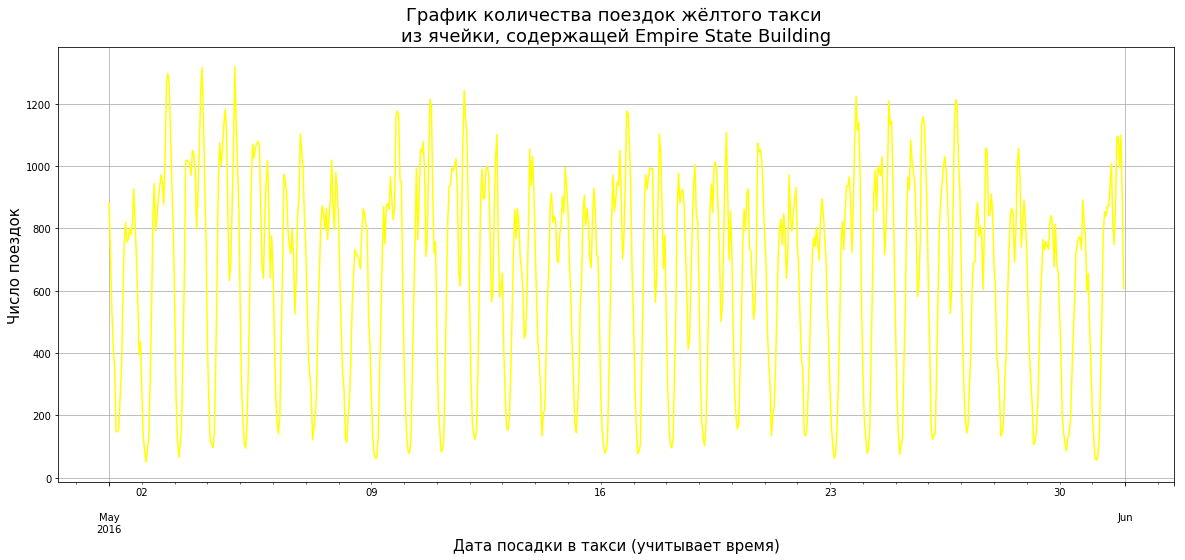

In [34]:
fig = plt.figure(figsize=(20, 8))
aggdata_2016_05[reg_EMB].plot(grid=True, color='yellow')
plt.title('График количества поездок жёлтого такси \nиз ячейки, содержащей Empire State Building', fontsize=18)
plt.xlabel('Дата посадки в такси (учитывает время)', fontsize=15)
plt.ylabel('Число поездок', fontsize=15);

## Колонна с датой содержит время поэтому такие колебания.

### 6. Посчитаем, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки

In [38]:
number_zero_pairs = np.array([aggdata_2016_05[col].value_counts()[0] if 0 in aggdata_2016_05[col].value_counts().index else 0
                             for col in aggdata_2016_05.columns]).sum()
print("Ответ: {} пар".format(number_zero_pairs))

Ответ: 1718238 пар


### 7. Функция предобработки данных
В завершении раздела на основе отлаженных действий по предобработке данных сделаем единую (общую) функцию, которая получает на вход путь к файлу с данными за месяц и записывает агрегированные по часам и областям данные в csv-файл с названием типа **'aggdata_2016-05.csv'**

In [35]:
def data_preprocessing(file_name, path_to_data=path_to_data, output_file_prefix='aggdata'):
    '''
    Эта функция получает на вход путь к файлу с данными за месяц, после чего формирует и записывает 
    агрегированные по часам и областям данные в csv-файл с названием типа 'aggdata_2016-05.csv'
    '''
    
    
    data = pd.read_csv(os.path.join(path_to_data, file_name), 
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    
    # границы Нью-Йорка
    west_bound = -74.25559
    east_bound = -73.70001
    south_bound = 40.49612
    north_bound = 40.91553
    
    # фильтруем данные от выбросов и некорректностей
    drop_indexes = data[(data['tpep_dropoff_datetime'] == data['tpep_pickup_datetime']) | 
                    (data['passenger_count'] == 0) | 
                    (data['trip_distance'] == 0) | 
                    (west_bound > data['pickup_longitude']) | (data['pickup_longitude'] > east_bound) | 
                    (south_bound > data['pickup_latitude']) | (data['pickup_latitude'] > north_bound)].index
    data.drop(drop_indexes, inplace=True)
    
    # отбрасываем минуты и секунды (округляем вниз до часов)
    data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].dt.floor('h')
    
    # оставляем только нужные колонки (освобождаем память)
    data = data[['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude']]
        
    # --------------------------------------------------------------------------
    def count_statistic(df, col1='pickup_longitude', col2='pickup_latitude'):
        '''
        агрегируем данные в Датафрейме по времени (по часам), берем поле statistic (оно получилось 50х50) и вытягиваем его
        '''
        ret = binned_statistic_2d(df[col1], df[col2], None, 'count', bins=50, 
                                  range=[[west_bound, east_bound], [south_bound, north_bound]])
        return ret.statistic.astype(int).ravel()
    # --------------------------------------------------------------------------    
    def to_df(s):
        '''
        преобразовываем в датафрейм, в котором названия колонок - идентификаторы ячеек (str)
        ''' 
        df = pd.DataFrame.from_records(s.values, index=s.index, columns=(np.arange(2500) + 1).astype(str))
        return df
    # --------------------------------------------------------------------------    
    def control_timeindex(aggdata, month):
        '''
        Добавляет недостающие временные метки-индексы (если они есть) и заполняет пустоты нулями.
        Эта функция - на всякий случай, если вдруг есть пропуски в индексе-временном ряде.
        month - str, текущий год и месяц (пример - '2016-05')
        '''
        start = month
        end = (datetime.strptime(start, '%Y-%m') + MonthBegin()).strftime('%Y-%m') # конечная дата через месяц
        
        ind = pd.date_range(start, end, freq='H')[:-1] # полный временной ряд (без последнего лишнего значения)
        
        # ИТОГО - дополнительный датафрейм с нулями заведомо "правильной" конфигурации, без пропусков:
        df = pd.DataFrame(np.zeros((len(ind), 2500)), index=ind, columns=(np.arange(2500) + 1).astype(str)) 
        df.index.name = 'tpep_pickup_datetime'
        
        # складываем его с основным датафреймом (в пропусках - наны, которые мы заполняем)
        df = (aggdata + df).fillna(0).astype(int)
        
        return df
    # --------------------------------------------------------------------------
    month = file_name[-11:-4] # вытягивам из названия текущий месяц
    
    # агрегируем данные    
    aggdata = control_timeindex(to_df(data.groupby('tpep_pickup_datetime').apply(count_statistic)), month)
    
    # записываем сформированный файл
    aggdata.to_csv(os.path.join(path_to_data, output_file_prefix + '_' + month + '.csv'))
    
    pass

тестируем

In [39]:
%%time
data_preprocessing('yellow_tripdata_2016-05.csv')

C:\Users\ilyaivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Wall time: 4min 38s


In [40]:
def read_aggdata(file_name):
    return pd.read_csv(os.path.join(path_to_data, file_name), index_col=0, parse_dates=True)

In [41]:
aggdata_2016_05_test = read_aggdata('aggdata_2016-05.csv')

In [42]:
aggdata_2016_05_test.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


контрольная сумма

In [43]:
aggdata_2016_05_test.sum().sum()

11626521

Совпадают ли рабочий и тестовый датафрейм:

In [44]:
(aggdata_2016_05_test == aggdata_2016_05).all().all()

True

### 8. Контрольная проверка того, что названия, которые мы присвоили колонкам, соответствуют идентификаторам ячеек из приложенного файла regions.csv

Для этого сгенерируем датафрейм с одной поездкой, соответствующей зданию **Empire State Building**, и проверим, к какой ячейке полученный алгоритм ее отнесет. Должна быть ячейка **1231**.

In [45]:
long_EMB = -73.985756
lat_EMB = 40.748306

test_data = pd.DataFrame({
                        'pickup_longitude':long_EMB,
                        'pickup_latitude':lat_EMB,
                        'tpep_pickup_datetime':'2016-05-01',
                        'tpep_dropoff_datetime':'2016-05-02',
                        'passenger_count':1,
                        'trip_distance':1,
                        }, index=[0])
test_data.to_csv(os.path.join(path_to_data, 'test_data_2016-05.csv'))
test_data

,pickup_longitude,pickup_latitude,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance
0,-73.985756,40.748306,2016-05-01,2016-05-02,1,1


In [46]:
test_data = pd.read_csv(os.path.join(path_to_data, 'test_data_2016-05.csv'), 
                   parse_dates=['tpep_pickup_datetime'], index_col=0)
test_data

,pickup_longitude,pickup_latitude,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance
0,-73.985756,40.748306,2016-05-01,2016-05-02,1,1


In [47]:
data_preprocessing('test_data_2016-05.csv', output_file_prefix='test_aggdata')

C:\Users\ilyaivanov\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [52]:
test_aggdata = read_aggdata('test_aggdata_2016-05.csv')

In [53]:
test_aggdata.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# контрольная сумма
test_aggdata.sum().sum()

1

In [57]:
test_aggdata.sum()[aggtest_data.sum() == 1].index[0] == '1231'

NameError: name 'aggtest_data' is not defined